# A Regression Analysis Demonstration of Chainer Neural Network Library

Let's go a little further than [SimpleChainer](SimpleChainer.ipynb) and fit a neural network to a function.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import chainer
import chainer.functions as F
import chainer.links as L
import chainer.initializers as I
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class Regressor(chainer.Chain):
    def __init__(self, outputs=1, n_units=128):
        super(Regressor, self).__init__(
            l1 = L.Linear(None, n_units),
            l2 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = self.l2(h1)
        return h2

In [21]:
class Regressor2(chainer.Chain):
    def __init__(self, outputs=1, n_units=128):
        super(Regressor2, self).__init__(
            l1 = L.Linear(None, n_units),
            l2 = L.Linear(n_units, n_units),
            l3 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [35]:
class Regressor3(chainer.Chain):
    def __init__(self, outputs=1, n_units=128):
        w = I.Normal()
        super(Regressor3, self).__init__(
            l1 = L.Linear(None, n_units, initialW=w),
            l2 = L.Linear(n_units, n_units, initialW=w),
            l3 = L.Linear(n_units, n_units, initialW=w),
            l4 = L.Linear(n_units, outputs, initialW=w)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        return self.l4(h3)

In [112]:
def loadimg(dtype=np.float32):
    import scipy.ndimage
    # First, load the data
    img = sp.ndimage.imread('DSC_0420.jpg', True)
    def c(x): return np.array(x,dtype=dtype)
    return c(img) / 256.

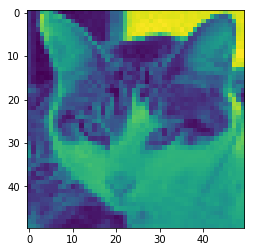

In [113]:
img = loadimg()
plt.imshow(img)

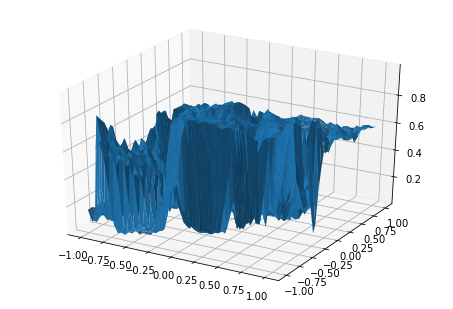

In [114]:
x, y = np.linspace(-1, 1, img.shape[1]), np.linspace(-1, 1, img.shape[0])
X, Y = np.meshgrid(x, y)
X, Y = X.astype(np.float32), Y.astype(np.float32)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X,Y,img)

In [121]:
def run_train(trainx, trainy, epoch=10000, report_period=100, report_period_seconds=0, regularize=0.0001):
    from time import clock
    start = clock()
    last_report = start
    model = Regressor3(trainy.shape[1], 256)

    model.zerograds()

    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)
    optimizer.add_hook(chainer.optimizer.WeightDecay(regularize))
    loss_hist = []

    for i in range(epoch):
        loss = F.mean_squared_error(model(trainx), trainy)
        loss_hist.append(loss.data)
        if i % report_period == 0:
            if last_report + report_period_seconds < clock():
                ups = i / (clock() - start)
                eta = (epoch - i) / ups if ups != 0 else 0
                etas = '%d:%05.2f' % (eta // 60, eta % 60) if 60 < eta else '%.2f' % eta
                print(i, 'loss', loss.data, ', ups: %.2f' % ups, ', eta: ' + etas)
                last_report = clock()
        #optimizer.weight_decay(0.005)
        optimizer.update(lambda x,y: F.mean_squared_error(model(x), y), trainx, trainy)

    return model, loss_hist

In [122]:
trainx = np.vstack((X.flat, Y.flat)).T
trainy = np.array(img.flat)[np.newaxis].T
model, loss_hist = run_train(trainx, trainy, epoch=5000, report_period=100, report_period_seconds=5, regularize=0.000001)

100 loss 0.024353202432394028 , ups: 18.99 , eta: 4:18.00
200 loss 0.01242486760020256 , ups: 18.97 , eta: 4:13.06
300 loss 0.009425533935427666 , ups: 18.98 , eta: 4:07.68
400 loss 0.008272409439086914 , ups: 18.94 , eta: 4:02.82
500 loss 0.0066337576135993 , ups: 18.92 , eta: 3:57.82
600 loss 0.005416330881416798 , ups: 18.94 , eta: 3:52.29
700 loss 0.005049955565482378 , ups: 18.92 , eta: 3:47.26
800 loss 0.004210356157273054 , ups: 18.88 , eta: 3:42.48
900 loss 0.004209697712212801 , ups: 18.88 , eta: 3:37.17
1000 loss 0.0036415932700037956 , ups: 18.86 , eta: 3:32.06
1100 loss 0.0035147941671311855 , ups: 18.80 , eta: 3:27.44
1200 loss 0.0031080625485628843 , ups: 18.77 , eta: 3:22.50
1300 loss 0.0027999503072351217 , ups: 18.77 , eta: 3:17.17
1400 loss 0.0024731471203267574 , ups: 18.75 , eta: 3:12.04
1500 loss 0.0033822234254330397 , ups: 18.73 , eta: 3:06.90
1600 loss 0.0035876051988452673 , ups: 18.69 , eta: 3:01.90
1700 loss 0.0021258804481476545 , ups: 18.66 , eta: 2:56.86
1

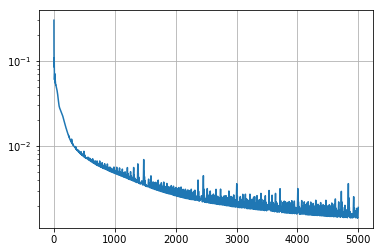

In [118]:
plt.semilogy(loss_hist)
plt.grid()

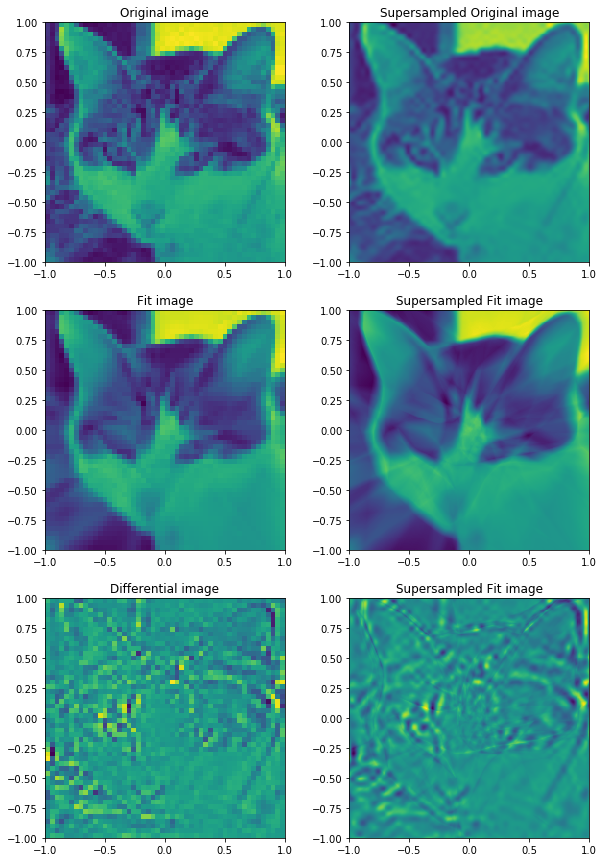

In [120]:
upx, upy = np.linspace(min(x),max(x),len(x)*5), np.linspace(min(y),max(y),len(y)*5)
upX, upY = np.meshgrid(upx, upy)
upX, upY = upX.astype(np.float32), upY.astype(np.float32)
upXY = np.vstack((upX.flat, upY.flat)).T

import scipy.interpolate
upimg = sp.interpolate.interp2d(x, y, img, kind='cubic')(upx, upy)

fig, axs = plt.subplots(3,2,figsize=(10,15))

axs[0,0].imshow(img,extent=(min(x), max(x), min(y), max(y)))
axs[0,0].set_title('Original image')
axs[1,0].imshow(model(trainx).data.reshape(X.shape),extent=(min(x), max(x), min(y), max(y)))
axs[1,0].set_title('Fit image')
axs[2,0].imshow(img - model(trainx).data.reshape(X.shape),extent=(min(x), max(x), min(y), max(y)))
axs[2,0].set_title('Differential image')
axs[0,1].imshow(upimg, extent=(min(x), max(x), min(y), max(y)))
axs[0,1].set_title('Supersampled Original image')
axs[1,1].imshow(model(upXY).data.reshape(upX.shape),extent=(min(x), max(x), min(y), max(y)))
axs[1,1].set_title('Supersampled Fit image')
axs[2,1].imshow(upimg - model(upXY).data.reshape(upX.shape),extent=(min(x), max(x), min(y), max(y)))
axs[2,1].set_title('Supersampled Fit image')


In [72]:
print(upx.shape,upy.shape,img.shape)

(250,) (250,) (50, 50)


In [73]:
sp.interpolate.interp2d?

In [63]:
I.Normal?